<a href="https://www.kaggle.com/code/ndannnop/computer-vision?scriptVersionId=240877749" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install pybcf pysam keras-layer-normalization

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 75.7 MB/s eta 0:00:00:00:0100:01
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4654 sha256=f3bba1ba49e530f6316ac79d15759e86cea42056481e075d98cfdec5c8927bf1
  Stored in directory: /root/.cache/pip/wheels/0f/c4/a1/24f1ca7fd39e75f4d8dab7feda6fe3e2163d8062b29f1169fb
Successfully built keras-layer-normalization


# Preprocessing

In [2]:
# import libraries
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from io import BytesIO
import os
import random
import math # Needed for ceiling division

import easyocr
import numpy as np
import os
import tempfile
from PIL import Image

# Global OCR reader for efficiency
_ocr_reader = None

def get_ocr_reader(languages=["en"]):
    global _ocr_reader
    if _ocr_reader is None:
        _ocr_reader = easyocr.Reader(languages)
    return _ocr_reader

def extract_patches(image_array, num_patch=3, patch_size=(105, 105), 
                    extract_text=True, min_text_coverage=0.3, max_attempts=20):
    patch_h, patch_w = patch_size

    # Determine if grayscale or color
    if image_array.ndim == 2:
        h, w = image_array.shape
        is_grayscale = True
    elif image_array.ndim == 3:
        h, w, _ = image_array.shape
        is_grayscale = False
    else:
        print(f"Unexpected image shape: {image_array.shape}")
        return []

    # === Step 1: Resize image to height = 105, maintain aspect ratio ===
    scale_factor = patch_h / h
    new_w = int(w * scale_factor)
    if is_grayscale:
        resized = cv2.resize(image_array, (new_w, patch_h), interpolation=cv2.INTER_LINEAR)
    else:
        resized = cv2.resize(image_array, (new_w, patch_h), interpolation=cv2.INTER_LINEAR)

    # === Step 2: Check if width is enough for patch ===
    if new_w < patch_w:
        return []

    # === Step 3: If not extracting text, return random crops ===
    if not extract_text:
        patches = []
        for _ in range(num_patch):
            x = np.random.randint(0, new_w - patch_w + 1)
            if is_grayscale:
                patch = resized[:, x:x + patch_w]
            else:
                patch = resized[:, x:x + patch_w, :]
            patches.append(patch)
        return patches

    # === Step 4: Try to find text patches using OCR ===
    reader = get_ocr_reader()
    text_patches = []
    attempts = 0

    while len(text_patches) < num_patch and attempts < max_attempts:
        x = np.random.randint(0, new_w - patch_w + 1)
        if is_grayscale:
            patch = resized[:, x:x + patch_w]
        else:
            patch = resized[:, x:x + patch_w, :]

        # Save patch to temporary file for OCR
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp:
            tmp_path = tmp.name
            patch_img = Image.fromarray(patch)
            patch_img.save(tmp_path)

        try:
            ocr_results = reader.readtext(tmp_path)
            os.unlink(tmp_path)

            patch_area = patch_h * patch_w
            text_area = 0
            for bbox, text, conf in ocr_results:
                if conf < 0.5:
                    continue
                bbox = [[int(p[0]), int(p[1])] for p in bbox]
                min_x = max(0, min(p[0] for p in bbox))
                max_x = min(patch_w, max(p[0] for p in bbox))
                min_y = max(0, min(p[1] for p in bbox))
                max_y = min(patch_h, max(p[1] for p in bbox))
                if max_x > min_x and max_y > min_y:
                    text_area += (max_x - min_x) * (max_y - min_y)

            if text_area / patch_area >= min_text_coverage:
                text_patches.append(patch)

        except Exception as e:
            print(f"OCR error: {e}")
            try:
                os.unlink(tmp_path)
            except:
                pass

        attempts += 1

    return text_patches



In [3]:
# augmentation functions
import random
import numpy as np
import cv2
from PIL import Image, ImageFilter

TARGET_SIZE = (105, 105)

def to_uint8(img: np.ndarray) -> np.ndarray:
    return np.clip(img, 0, 255).astype(np.uint8)

def noise_image(img: np.ndarray, mean=0.0, std=3.0) -> np.ndarray:
    """Add Gaussian noise."""
    f = img.astype(np.float32)
    n = np.random.normal(mean, std, f.shape).astype(np.float32)
    return to_uint8(f + n)

def blur_image(img: np.ndarray, sigma_range=(0.5, 1.5)) -> np.ndarray:
    """
    Apply a mild, randomly‐parameterized Gaussian blur.
    
    Args:
        img (np.ndarray): Input image, either H×W or H×W×C, dtype uint8.
        sigma_range (tuple): Min/max sigma for the blur kernel.
    
    Returns:
        np.ndarray: Blurred image, same shape and dtype uint8.
    """
    # Ensure float for convolution
    f = img.astype(np.float32)
    # Randomize sigma in the given range
    sigma = random.uniform(*sigma_range)
    # OpenCV: kernel size (0,0) triggers automatic size based on sigma
    if f.ndim == 2:
        blurred = cv2.GaussianBlur(f, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
    else:
        # Split channels and blur each independently
        channels = cv2.split(f)
        channels = [cv2.GaussianBlur(ch, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
                    for ch in channels]
        blurred = cv2.merge(channels)
    # Restore uint8
    return np.clip(blurred, 0, 255).astype(np.uint8)

def affine_rotation(img: np.ndarray, max_deg=10) -> np.ndarray:
    """Small random affine warp."""
    h, w = img.shape[:2]
    # random shift on three points
    src = np.float32([[0,0],[w-1,0],[0,h-1]])
    dx = w * 0.05
    dy = h * 0.05
    dst = src + np.random.uniform([-dx, -dy], [dx, dy], src.shape).astype(np.float32)
    M = cv2.getAffineTransform(src, dst)
    warped = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return warped

def shading_gradient(img: np.ndarray) -> np.ndarray:
    """Multiply by a random horizontal or vertical linear illumination gradient."""
    h, w = img.shape[:2]
    start, end = random.uniform(0.6,1.4), random.uniform(0.6,1.4)
    if random.choice([True,False]):
        # horizontal
        grad = np.linspace(start, end, w, dtype=np.float32)[None,:]
        mask = np.repeat(grad, h, axis=0)
    else:
        # vertical
        grad = np.linspace(start, end, h, dtype=np.float32)[:,None]
        mask = np.repeat(grad, w, axis=1)
    if img.ndim==3:
        mask = mask[:,:,None]
    shaded = img.astype(np.float32) * mask
    return to_uint8(shaded)

def variable_aspect_ratio_preprocess(img: np.ndarray) -> np.ndarray:
    """Squeeze width by a random factor in [5/6,7/6], then pad/crop to original."""
    h, w = img.shape[:2]
    factor = random.uniform(5/6, 7/6)
    new_w = max(1, int(w/factor))
    resized = cv2.resize(img, (new_w, h), interpolation=cv2.INTER_LINEAR)
    # pad or crop back to w x h
    if new_w < w:
        pad = ( (0,0), ( (w-new_w)//2, (w-new_w)-(w-new_w)//2 ) ) + ((0,0),) if img.ndim==3 else ( (0,0), ( (w-new_w)//2, (w-new_w)-(w-new_w)//2 ) )
        resized = np.pad(resized, pad, mode='reflect')
    else:
        x0 = (new_w - w)//2
        resized = resized[:, x0:x0+w]
    return resized

def final_resize(img: np.ndarray, size=TARGET_SIZE) -> np.ndarray:
    """Resize to target patch size."""
    return cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)

def augmentation_pipeline(img: np.ndarray) -> np.ndarray:
    """
    Apply a random subset of the six DeepFont augmentations:
      - noise, blur, affine warp, shading, variable spacing (as AR squeeze)
      - note: gradient_fill (Laplacian) dropped since shading covers illumination.
    Finally, resize to TARGET_SIZE.
    """
    # Ensure uint8
    img = to_uint8(img)
    # 1) variable aspect ratio
    img = variable_aspect_ratio_preprocess(img)
    # 2) choose 2–4 augmentations from the pool
    pool = [
        noise_image,
        blur_image,
        affine_rotation,
        shading_gradient
    ]
    for fn in pool:
        img = fn(img)
    # 3) final resize
    img = final_resize(img)
    return img


In [4]:
# image dataset
import torch
from PIL import Image
import numpy as np
import os
from io import BytesIO
# from datasets import Dataset
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    """
    A dataset class that combines both .jpeg files and .bcf files into a single dataset.
    This class can handle loading and patch extraction from both .jpeg and .bcf files.
    """
    def __init__(self, jpeg_dir, bcf_file, label_file, testing=False, num_patch=3, patch_size=(105, 105), 
                 extract_text=False, min_text_coverage=0.3, max_attempts=20, ocr_languages=["en"]):
        """
        Initializes the dataset by loading both jpeg files and bcf files into one dataset.

        Args:
            jpeg_dir (str): Directory containing .jpeg files.
            bcf_file (str): Path to the .bcf file.
            label_file (str): Path to the label file corresponding to the .bcf file.
            num_patch (int): Number of patches to extract per image.
            patch_size (tuple): Tuple (height, width) for the size of the patches.
            extract_text (bool): Whether to prioritize patches containing text
            min_text_coverage (float): Minimum ratio of text area to patch area (0-1)
            max_attempts (int): Maximum number of attempts to find text patches
            ocr_languages (list): Languages for EasyOCR to detect
        """
        self.jpeg_dir = jpeg_dir
        self.bcf_file = bcf_file
        self.label_file = label_file
        self.testing = testing
        self.num_patch = num_patch
        self.patch_size = patch_size
        self.extract_text = extract_text
        self.min_text_coverage = min_text_coverage
        self.max_attempts = max_attempts
        self.ocr_languages = ocr_languages

        # Initialize OCR reader if needed
        if extract_text:
            self.reader = get_ocr_reader(ocr_languages)

        self.jpeg_data = []
        self.bcf_data = []

        # Load jpeg data
        self._load_jpeg_data(jpeg_dir)

        # Load bcf data
        self._load_bcf_data(bcf_file, label_file)

    def _extract_patches_test(self, img_array):
        h, w = img_array.shape[:2]
        target_h, target_w = self.patch_size
        # 1) resize height
        new_w = int(w * (target_h / h))
        img = cv2.resize(img_array, (new_w, target_h), interpolation=cv2.INTER_LINEAR)
        patches = []
        for _scale in range(3):
            factor = np.random.uniform(1.5, 3.5)
            sw = max(1, int(new_w / factor))
            squeezed = cv2.resize(img, (sw, target_h), interpolation=cv2.INTER_LINEAR)
            # nếu width < target_w thì pad reflect, else crop giữa
            if sw < target_w:
                pad = target_w - sw
                left = pad//2; right = pad-left
                squeezed = np.pad(squeezed,
                                  ((0,0),(left,right)) + ((0,0),)*(img.ndim-2),
                                  mode='reflect')
            else:
                x0 = (sw - target_w)//2
                squeezed = squeezed[:, x0:x0+target_w]
            # crop 5 patch random
            for _ in range(5):
                x = np.random.randint(0, target_w - target_w + 1)
                y = np.random.randint(0,      0  + 1)  # vì height==target_h
                patch = squeezed[y:y+target_h, x:x+target_w] if img.ndim==2 \
                        else squeezed[y:y+target_h, x:x+target_w, :]
                patches.append(patch)
        return patches

    def _load_jpeg_data(self, jpeg_dir):
        """Loads the .jpeg files from the specified directory."""
        if not os.path.exists(jpeg_dir):
            print(f"Warning: JPEG directory {jpeg_dir} does not exist.")
            return
            
        image_filenames = [f for f in os.listdir(jpeg_dir) if f.lower().endswith(('.jpeg', '.jpg'))]
        self.jpeg_data = [(os.path.join(jpeg_dir, f), 0) for f in image_filenames]  # Assuming label is 0 for .jpeg files
        print(f"Loaded {len(self.jpeg_data)} .jpeg images.")

    def _load_bcf_data(self, bcf_file, label_file):
        """Loads the .bcf file and the associated label file."""
        if not (os.path.exists(bcf_file) and os.path.exists(label_file)):
            print(f"Warning: BCF file {bcf_file} or label file {label_file} does not exist.")
            return
            
        try:
            with open(label_file, 'rb') as f:
                self.labels = np.frombuffer(f.read(), dtype=np.uint32)
                print(f"Loaded {len(self.labels)} labels from {label_file}.")

            with open(bcf_file, 'rb') as f:
                self.num_images = np.frombuffer(f.read(8), dtype=np.int64)[0]
                print(f"Loaded {self.num_images} images from {bcf_file}.")

                sizes_bytes = f.read(self.num_images * 8)
                self.image_sizes = np.frombuffer(sizes_bytes, dtype=np.int64)

                self.data_start_offset = 8 + self.num_images * 8
                self.image_offsets = np.zeros(self.num_images + 1, dtype=np.int64)
                np.cumsum(self.image_sizes, out=self.image_offsets[1:])

                for idx in range(self.num_images):
                    self.bcf_data.append((idx, self.labels[idx]))
                
            print(f"Loaded {len(self.bcf_data)} .bcf images.")
        except Exception as e:
            print(f"Error loading .bcf data: {e}")

    def __len__(self):
        """Returns the total number of images in the combined dataset."""
        return len(self.jpeg_data) + len(self.bcf_data)

    def _extract_patches(self, img_array):
        """Helper function to extract patches from an image."""
        return extract_patches(
            img_array, 
            num_patch=self.num_patch, 
            patch_size=self.patch_size,
            extract_text=self.extract_text, 
            min_text_coverage=self.min_text_coverage,
            max_attempts=self.max_attempts
        )

    def __getitem__(self, idx):
        """Fetches one item with robust error handling for corrupted images."""
        # Handle case where idx is a list (batch loading)
        if isinstance(idx, list):
            # Handle batch indices properly
            results = []
            labels = []
            for single_idx in idx:
                try:
                    patches, label = self.__getitem__(single_idx)  # Call recursively with single index
                    if patches and label != -1:
                        results.append(patches)
                        labels.append(label)
                except Exception as e:
                    print(f"Error processing index {single_idx}: {e}")
                    # Skip this item on error
            
            # Return whatever valid items we were able to get
            return results, labels
        
        # Original single-item loading logic
        max_retries = 3  # Try a few times before giving up on an index
        
        for retry in range(max_retries):
            try:
                if idx < len(self.jpeg_data):
                    # JPEG image with error handling
                    img_path, label = self.jpeg_data[idx]
                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")  # Ignore PIL warnings
                            img = Image.open(img_path)
                            img.verify()  # Verify image is not corrupted
                        
                        # Re-open since verify() closes the file
                        img = Image.open(img_path).convert('L')
                        img_array = np.array(img)
                        patches = self._extract_patches(img_array)
                        # patches = [augmentation_pipeline(patch) for patch in patches]
                        
                        # Clean memory
                        del img, img_array
                        
                        return patches, label
                    
                    except (OSError, IOError, ValueError) as e:
                        # Image is corrupted, return empty list
                        print(f"Warning: Corrupt image at {img_path}: {e}")
                        return [], -1
                        
                else:
                    # BCF image with error handling
                    bcf_idx = idx - len(self.jpeg_data)
                    if bcf_idx >= len(self.bcf_data):
                        return [], -1
                        
                    label = self.bcf_data[bcf_idx][1]
                    offset = self.image_offsets[bcf_idx]
                    size = self.image_sizes[bcf_idx]
                    
                    try:
                        with open(self.bcf_file, 'rb') as f:
                            f.seek(self.data_start_offset + offset)
                            image_bytes = f.read(size)
                        
                        # Use BytesIO to catch corruption
                        buffer = BytesIO(image_bytes)
                        img = Image.open(buffer)
                        img.verify()  # Verify it's valid
                        
                        # Re-open since verify() closes the file
                        buffer.seek(0)
                        img = Image.open(buffer).convert('L')
                        img_array = np.array(img)
                        
                        if self.testing:
                            patches = self._extract_patches_test(img_array)
                        else:
                            patches = self._extract_patches(img_array)
                            patches = [augmentation_pipeline(patch) for patch in patches]
                        
                        # Clean memory
                        del img, img_array, buffer, image_bytes
                        
                        return patches, label
                    
                    except (OSError, IOError, ValueError) as e:
                        print(f"Warning: Corrupt BCF image at index {bcf_idx}: {e}")
                        return [], -1
                        
            except Exception as e:
                print(f"Unexpected error processing idx {idx}: {e}")
            
            # If we got here, there was an issue with this index - try a different one
            # Important: increment as an integer, not trying to add to a list
            if retry < max_retries - 1:  # Only increment if we have retries left
                idx = (int(idx) + 1) % len(self)
        
        # If all retries failed, return empty
        return [], -1

In [5]:
# memory_efficient_patch_collate_fn
import gc
import warnings
from functools import partial

# Add this memory-efficient patch collate function
def memory_efficient_patch_collate_fn(batch, patch_size_tuple):
    """
    Memory-efficient version of patch_collate_fn that processes one patch at a time
    and includes robust error handling.
    """
    import gc  # Import inside function for worker processes
    
    all_patches = []
    all_labels = []
    valid_batch_items = 0

    # Process one item at a time to avoid large memory allocations
    for item in batch:
        patches, label = item
        # Ensure item is valid
        if patches and label != -1:
            # Process patches one by one
            for patch in patches:
                all_patches.append(patch)
                all_labels.append(label)
            valid_batch_items += 1
    
    # Periodically force garbage collection
    if len(all_patches) > 100:
        gc.collect()
    
    # Empty batch handling
    if not all_patches:
        patch_h, patch_w = patch_size_tuple
        return torch.empty((0, 1, patch_h, patch_w), dtype=torch.float), torch.empty((0,), dtype=torch.long)

    # Process in smaller chunks to reduce peak memory usage
    max_chunk_size = 64  # Adjust based on your GPU memory
    num_patches = len(all_patches)
    patches_tensor_list = []
    
    for i in range(0, num_patches, max_chunk_size):
        chunk = all_patches[i:i+max_chunk_size]
        # Convert to NumPy array
        chunk_np = np.stack(chunk)
        # Convert to tensor, normalize and add channel dimension
        chunk_tensor = torch.from_numpy(chunk_np).float() / 255.0
        chunk_tensor = chunk_tensor.unsqueeze(1)
        patches_tensor_list.append(chunk_tensor)
        
        # Clear variables to free memory
        del chunk, chunk_np
    
    # Concatenate chunks
    patches_tensor = torch.cat(patches_tensor_list, dim=0)
    labels_tensor = torch.tensor(all_labels, dtype=torch.long)
    
    # Clean up
    del patches_tensor_list, all_patches, all_labels
    gc.collect()
    
    return patches_tensor, labels_tensor

# Add this function to create optimized DataLoaders
import torch
from torch.utils.data import DataLoader
from functools import partial

def create_optimized_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1):
    """
    Creates DataLoaders with proper error handling, avoiding HuggingFace datasets compatibility issues.
    
    Args:
        dataset: The image dataset instance
        batch_size: Batch size for training
        num_workers: Number of worker processes
        val_split: Validation split ratio (0-1)
        
    Returns:
        tuple: (train_loader, val_loader)
    """
    from torch.utils.data import DataLoader, Subset
    import numpy as np
    
    # Calculate split sizes
    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets - this avoids Hugging Face's __getitems__ implementation
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # Custom collate function with error handling
    def safe_collate(batch):
        # Filter out empty or invalid items
        valid_batch = [(patches, label) for patches, label in batch if patches and label != -1]
        
        if not valid_batch:
            # Return empty tensors if no valid items
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
        
        # Process valid items
        all_patches = []
        all_labels = []
        
        for patches, label in valid_batch:
            if isinstance(patches, list) and patches:
                all_patches.extend(patches)
                all_labels.extend([label] * len(patches))
        
        if not all_patches:
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
            
        # Convert to PyTorch tensors
        try:
            patches_np = np.array(all_patches)
            patches_tensor = torch.tensor(patches_np, dtype=torch.float) / 255.0
            
            # Add channel dimension if needed
            if len(patches_tensor.shape) == 3:  # (B, H, W)
                patches_tensor = patches_tensor.unsqueeze(1)  # -> (B, 1, H, W)
                
            labels_tensor = torch.tensor(all_labels, dtype=torch.long)
            return patches_tensor, labels_tensor
        except Exception as e:
            print(f"Error in collate function: {e}")
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
    
    # Create DataLoaders with minimal worker configuration for stability
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=safe_collate,
        pin_memory=False,
        persistent_workers=True if num_workers > 0 else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=safe_collate,
        pin_memory=False,
        persistent_workers=True if num_workers > 0 else False
    )
    
    return train_loader, val_loader

In [6]:
# collate functions
import torch
import numpy as np

def test_collate_fn(batch):
    """
    batch: list of tuples (patches_list, label)
      - patches_list: list of P numpy arrays of shape (H, W) or (H, W, C)
      - label: int
    Returns:
      - images: Tensor of shape (B, P, C, H, W)
      - labels: Tensor of shape (B,)
    """
    images = []
    labels = []
    for patches_list, label in batch:
        patch_tensors = []
        for patch in patches_list:
            # patch is a numpy array
            arr = patch
            # grayscale or RGB?
            if arr.ndim == 2:
                # (H, W) → (1, H, W)
                t = torch.from_numpy(arr).unsqueeze(0)
            else:
                # (H, W, C) → (C, H, W)
                t = torch.from_numpy(arr).permute(2, 0, 1)
            # normalize to [0,1] float
            t = t.float().div(255.0)
            patch_tensors.append(t)
        # stack P patches → (P, C, H, W)
        images.append(torch.stack(patch_tensors, dim=0))
        labels.append(label)
    # now batch them → (B, P, C, H, W) and (B,)
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels
    
def train_collate_fn(batch):
    """
    batch: list of (patches_list, label) where
      patches_list: list of P numpy arrays, each H×W or H×W×C
      label: int
    Returns:
      images: Tensor of shape (B*P, C, H, W)
      labels: Tensor of shape (B*P,)
    """
    imgs = []
    lbls = []
    for patches, label in batch:
        for patch in patches:
            arr = patch
            # to torch tensor: (H,W)→(1,H,W), (H,W,C)→(C,H,W)
            if arr.ndim == 2:
                t = torch.from_numpy(arr).unsqueeze(0)
            else:
                t = torch.from_numpy(arr).permute(2, 0, 1)
            # normalize to [0,1]
            imgs.append(t.float().div(255.0))
            lbls.append(label)
    images = torch.stack(imgs, dim=0)
    labels = torch.tensor(lbls, dtype=torch.long)
    return images, labels


In [8]:
# save and load dataset
import pickle

def save_dataset(dataset, filepath: str):
    """
    Serialize and save a CombinedImageDataset to disk.
    """
    with open(filepath, 'wb') as f:
        pickle.dump(dataset, f)
    print(f"Dataset saved to {filepath!r}")

def load_dataset(filepath: str):
    """
    Load a pickled CombinedImageDataset from disk.
    """
    with open(filepath, 'rb') as f:
        dataset = pickle.load(f)
    print(f"Dataset loaded from {filepath!r}")
    return dataset


In [15]:
synthetic_dataset = load_dataset("/kaggle/input/font-datasets-1/synthetic_dataset_200_labels.pkl")

Dataset loaded from '/kaggle/input/font-datasets-1/synthetic_dataset_200_labels.pkl'


In [10]:
len(synthetic_dataset)

200000

In [16]:
synthetic_dataset[0]

([array([[195, 196, 196, ...,  20,  20,  17],
         [195, 196, 195, ...,   3,   3,   3],
         [196, 196, 195, ...,   1,   1,   0],
         ...,
         [219, 219, 219, ...,   0,   0,   0],
         [220, 220, 219, ...,   0,   0,   0],
         [220, 220, 218, ...,   0,   0,   0]], dtype=uint8),
  array([[246, 246, 246, ..., 250, 250, 250],
         [246, 246, 246, ..., 250, 250, 250],
         [246, 246, 246, ..., 250, 250, 250],
         ...,
         [247, 246, 246, ...,  85,  59,  42],
         [246, 246, 246, ..., 164, 132, 111],
         [245, 246, 246, ..., 222, 202, 188]], dtype=uint8),
  array([[191, 192, 193, ..., 247, 253, 255],
         [189, 190, 191, ..., 247, 253, 255],
         [177, 178, 180, ..., 213, 218, 228],
         ...,
         [ 16,  16,  17, ...,   2,   2,   2],
         [ 34,  34,  34, ...,  10,  10,   7],
         [ 74,  74,  73, ...,  34,  34,  29]], dtype=uint8)],
 0)

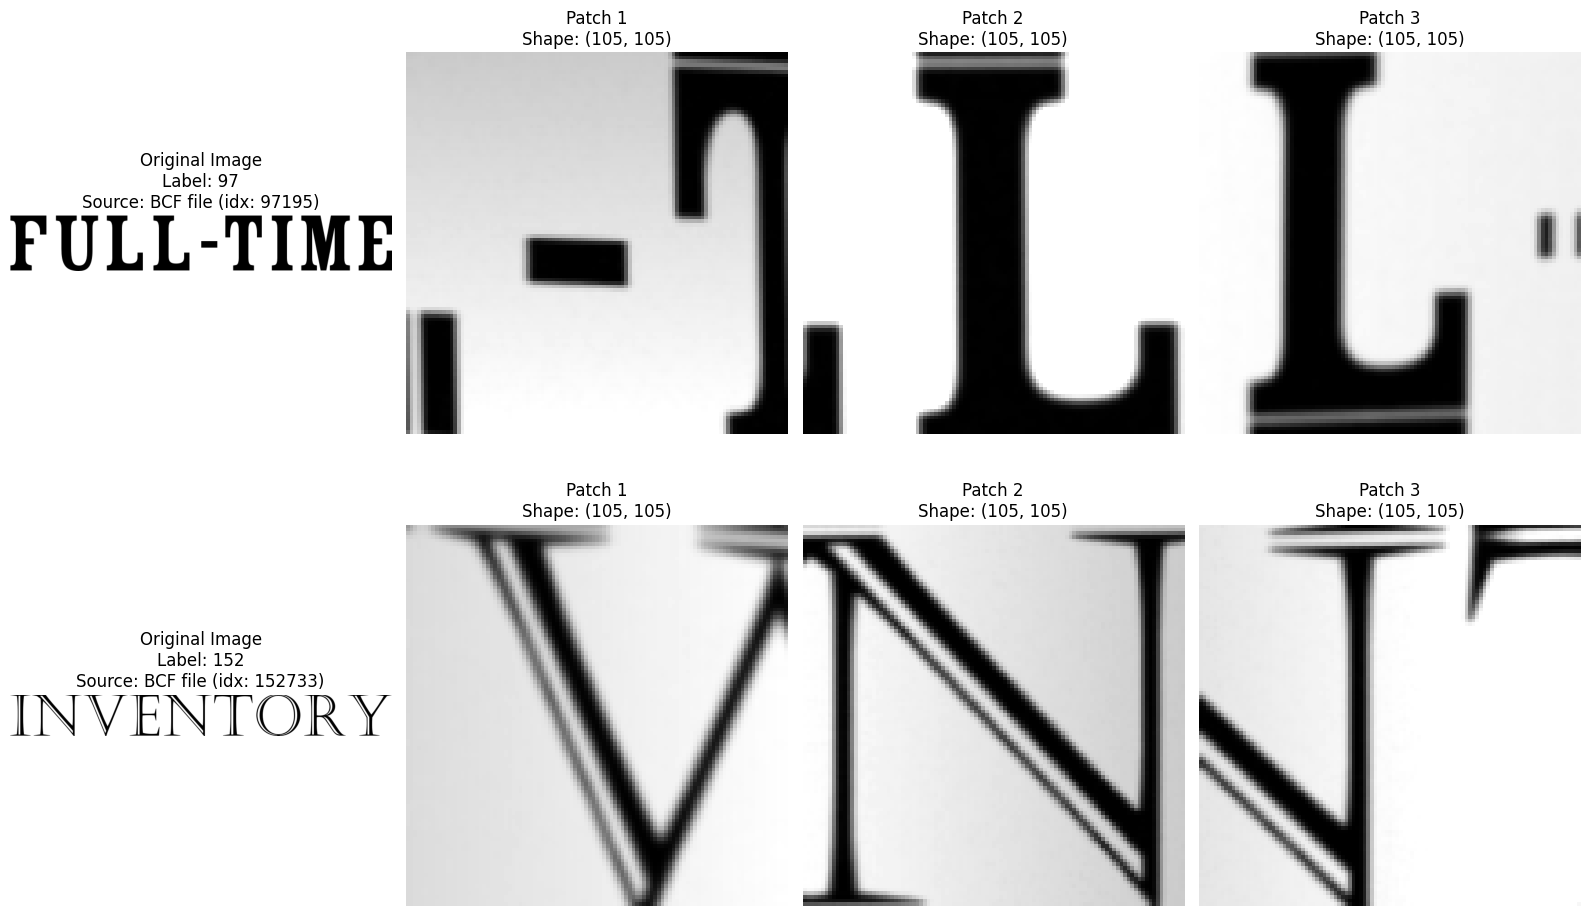

[97195, 152733]

In [17]:
# Visualization some samples from the combined dataset 
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageFile
from io import BytesIO
import os

def visualize_simple_images_and_patches(dataset, num_images=2, seed=None):
    # Allow loading of truncated images
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)
    
    # Find valid images (with patches)
    valid_indices = []
    attempts = 0
    max_attempts = min(len(dataset) * 2, 100)  # Limit search attempts
    
    while len(valid_indices) < num_images and attempts < max_attempts:
        idx = random.randint(0, len(dataset) - 1)
        if idx not in valid_indices:  # Avoid duplicates
            try:
                patches, label = dataset[idx]
                if patches and len(patches) > 0:
                    valid_indices.append(idx)
            except Exception as e:
                print(f"Error loading index {idx}: {e}")
            attempts += 1
    
    # If we couldn't find enough valid images
    if len(valid_indices) < num_images:
        print(f"Warning: Could only find {len(valid_indices)} valid images with patches")
        if len(valid_indices) == 0:
            print("No valid images found. Check your dataset.")
            return
    
    # Create figure with enough space for all elements
    fig, axes = plt.subplots(len(valid_indices), 4, figsize=(16, 5 * len(valid_indices)))
    
    # If only one image is requested, make axes indexable as 2D
    if len(valid_indices) == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(valid_indices):
        try:
            # Get item directly from dataset
            patches, label = dataset[idx]
            
            # Get the original full image
            img_array = None
            
            if hasattr(dataset, 'jpeg_data') and idx < len(dataset.jpeg_data):
                # From jpeg_data
                img_path, _ = dataset.jpeg_data[idx]
                img = Image.open(img_path).convert('L')
                img_array = np.array(img)
                source = f"JPEG file: {os.path.basename(img_path)}"
                
            elif hasattr(dataset, 'image_filenames') and not hasattr(dataset, 'num_images'):
                # From BCFImagePatchDataset with JPEG source
                img_path = os.path.join(dataset.data_source, dataset.image_filenames[idx])
                img = Image.open(img_path).convert('L')
                img_array = np.array(img)
                source = f"JPEG file: {dataset.image_filenames[idx]}"
                
            else:
                # From BCF file (either CombinedImageDataset or BCFImagePatchDataset)
                if hasattr(dataset, 'bcf_data'):
                    # CombinedImageDataset
                    bcf_idx = idx - len(dataset.jpeg_data)
                    if bcf_idx < 0 or bcf_idx >= len(dataset.bcf_data):
                        print(f"Invalid BCF index: {bcf_idx}")
                        continue
                        
                    offset = dataset.image_offsets[bcf_idx]
                    size = dataset.image_sizes[bcf_idx]
                    data_file = dataset.bcf_file
                    data_start = dataset.data_start_offset
                    source = f"BCF file (idx: {bcf_idx})"
                else:
                    # BCFImagePatchDataset
                    offset = dataset.image_offsets[idx]
                    size = dataset.image_sizes[idx]
                    data_file = dataset.data_source
                    data_start = dataset.data_start_offset
                    source = f"BCF file (idx: {idx})"
                
                with open(data_file, 'rb') as f:
                    f.seek(data_start + offset)
                    image_bytes = f.read(size)
                img = Image.open(BytesIO(image_bytes)).convert('L')
                img_array = np.array(img)
            
            # Plot original image if we successfully loaded it
            if img_array is not None:
                axes[i, 0].imshow(img_array, cmap='gray')
                axes[i, 0].set_title(f"Original Image\nLabel: {label}\nSource: {source}")
                axes[i, 0].axis('off')
            else:
                axes[i, 0].text(0.5, 0.5, "Image loading failed", ha='center', va='center')
                axes[i, 0].axis('off')
            
            # Plot the patches - ensure we have patches to display
            if patches and len(patches) > 0:
                for j in range(3):
                    if j < len(patches):
                        patch = patches[j]
                        axes[i, j+1].imshow(patch, cmap='gray')
                        axes[i, j+1].set_title(f"Patch {j+1}\nShape: {patch.shape}")
                    else:
                        # No more patches to display
                        axes[i, j+1].text(0.5, 0.5, "No patch", ha='center', va='center')
                    axes[i, j+1].axis('off')
            else:
                # No patches for this image
                for j in range(3):
                    axes[i, j+1].text(0.5, 0.5, "No patches extracted", ha='center', va='center')
                    axes[i, j+1].axis('off')
            
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            # Create error message in subplot
            for j in range(4):
                axes[i, j].text(0.5, 0.5, f"Error: {str(e)[:50]}...", ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Return the indices we used (helpful for debugging)
    return valid_indices

# Example usage:
visualize_simple_images_and_patches(synthetic_dataset)

In [ ]:
synthetic_dataset = load_dataset("/kaggle/working/synthetic_dataset.pkl")

In [ ]:
len(synthetic_dataset)

In [7]:
import torch
import torch.nn as nn
import os
import gc
from tqdm import tqdm
from torch.utils.data import DataLoader

# Clean memory before starting
gc.collect()
torch.cuda.empty_cache()

jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
bcf_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf"
label_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label"

# Create dataset with smaller patch size and fewer patches per image
synthetic_dataset = ImageDataset(
    jpeg_dir="jpeg_dir",
    bcf_file=bcf_file,
    label_file=label_file,
    # testing=True,
    num_patch=3,  # Number of patches per image
)
# save_dataset(test_dataset, "/kaggle/working/test_datasets.pkl")

Loaded 200000 labels from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label.
Loaded 200000 images from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf.
Loaded 200000 .bcf images.


In [9]:
save_dataset(synthetic_dataset, "/kaggle/working/synthetic_dataset.pkl")

Dataset saved to '/kaggle/working/synthetic_dataset.pkl'


In [28]:
# tao dataset -> dataloader
from torch.utils.data import random_split

# test_dataset = load_dataset("/kaggle/input/font-datasets-1/test_dataset.pkl")

dataset = synthetic_dataset
# 1. Decide split sizes
total = len(dataset)
train_size = int(0.8 * total)
val_size   = total - train_size

# 2. Split with a fixed seed for reproducibility
train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# print(f"Train samples: {len(train_dataset)},  Eval samples: {len(val_dataset)}")


In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=test_collate_fn # test_collate_fn
)

In [29]:
# tao dataset -> dataloader

train_loader = DataLoader(
    train_dataset,
    batch_size=128, # 
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=train_collate_fn # test_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=train_collate_fn
)

In [30]:
# FORMAT cua synthetic: (batch_size, 1, 105,105), test: (batch_size, 15, 1, 105, 105)
for batch in train_loader:
    images, labels = batch
    print(f"Batch size: {images.size()}, Labels size: {labels.size()}")
    break  # Just check the first batch

Batch size: torch.Size([384, 1, 105, 105]), Labels size: torch.Size([384])


In [ ]:
import numpy as np
from torch.utils.data import Subset

ds = synthetic_dataset
# 1) Build a single labels array for the whole dataset
jpeg_labels = np.array([lbl for _, lbl in ds.jpeg_data], dtype=int)
bcf_labels  = ds.labels           # already an np.ndarray
all_labels  = np.concatenate((jpeg_labels, bcf_labels), axis=0)

# 2) Count frequencies and find the two rarest labels
counts     = np.bincount(all_labels)
present    = np.nonzero(counts)[0]
rarest_two = present[np.argsort(counts[present])[:2]]
print("Dropping labels:", rarest_two.tolist())

# 3) Make one boolean mask over all samples
mask_keep  = (all_labels != rarest_two[0]) & (all_labels != rarest_two[1])

# 4) Get the indices to keep (this is fast C‐side)
keep_idx   = np.nonzero(mask_keep)[0]

# 5) Wrap in a Subset without iterating the dataset
filtered = Subset(ds, keep_idx.tolist())

# 6) If you need the remaining unique labels, compute them via numpy
remaining_labels = present[~np.isin(present, rarest_two)]
print(f"Kept {len(filtered)} samples. Remaining labels ({len(remaining_labels)}): {remaining_labels}")


In [ ]:
len(combined_dataset)

In [8]:
import numpy as np

# synthetic_dataset = load_dataset("/kaggle/input/font-datasets/synthetic_dataset.pkl")
filtered = synthetic_dataset
unique_labels = np.unique(filtered.labels)

print(f"Number of unique labels: {unique_labels.size}")
print(f"Labels: {unique_labels}")



Number of unique labels: 200
Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


# SCAE

In [ ]:
# train_memory_efficient_model

import torch.cuda.amp as amp
import gc
import torch
import torch.nn as nn
import os
import gc
from tqdm import tqdm
from torch.utils.data import DataLoader

def train_memory_efficient_model(model, train_loader, val_loader=None, 
                                num_epochs=5, learning_rate=0.0001,
                                checkpoint_dir="/kaggle/working/"):
    """
    Memory-efficient training function for SCAE model.
    """
    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Setup device and optimization tools
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device} with {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")
    
    # Move model to device
    model = model.to(device)
    
    # Set up mixed precision training
    scaler = amp.GradScaler()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    # Track best model
    best_val_loss = float('inf')
    patience_counter = 0
    
    try:
        for epoch in range(num_epochs):
            # Clean memory before each epoch
            gc.collect()
            torch.cuda.empty_cache()
            
            # TRAINING PHASE
            model.train()
            running_loss = 0.0
            valid_batches = 0
            
            # Use tqdm for progress tracking
            pbar = tqdm(train_loader)
            pbar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train]")
            
            for batch_idx, (patches, _) in enumerate(pbar):
                # Skip empty batches
                if patches.numel() == 0:
                    continue
                
                # Move data to device
                patches = patches.to(device, non_blocking=True)
                
                # Mixed precision forward pass
                with amp.autocast():
                    outputs = model(patches)
                    loss = criterion(outputs, patches)
                
                # Backward pass with gradient scaling
                optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Update metrics
                running_loss += loss.item()
                valid_batches += 1
                
                # Update progress bar
                pbar.set_postfix(loss=f"{loss.item():.4f}")
                
                # Aggressive memory cleanup every few batches
                if batch_idx % 10 == 0:
                    del outputs, loss, patches
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
            
            # Calculate epoch metrics
            if valid_batches > 0:
                train_loss = running_loss / valid_batches
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}")
            else:
                print(f"Epoch {epoch+1}/{num_epochs}, No valid batches!")
                continue
                
            # Save checkpoint every epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, f"{checkpoint_dir}/model_epoch_{epoch+1}.pt")
            
            # VALIDATION PHASE
            if val_loader:
                val_loss = validate_memory_efficient(model, val_loader, criterion, device)
                scheduler.step(val_loss)
                
                # Early stopping logic
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), f"{checkpoint_dir}/best_model.pt")
                    print(f"New best model saved with val_loss: {val_loss:.6f}")
                else:
                    patience_counter += 1
                    if patience_counter >= 3:  # Adjust patience as needed
                        print("Early stopping triggered!")
                        break
    
    except Exception as e:
        print(f"Error during training: {e}")
        # Save emergency checkpoint
        torch.save(model.state_dict(), f"{checkpoint_dir}/emergency_model.pt")
        raise
        
    return model

def validate_memory_efficient(model, val_loader, criterion, device):
    """Memory-efficient validation function."""
    model.eval()
    running_loss = 0.0
    valid_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader)
        pbar.set_description(f"Validating")
        
        for patches, _ in pbar:
            if patches.numel() == 0:
                continue
                
            patches = patches.to(device, non_blocking=True)
            
            # Using mixed precision even for validation
            with amp.autocast():
                outputs = model(patches)
                loss = criterion(outputs, patches)
                
            running_loss += loss.item()
            valid_batches += 1
            
            # Update progress bar
            pbar.set_postfix(loss=f"{loss.item():.4f}")
            
            # Clean up
            del outputs, patches, loss
    
    if valid_batches > 0:
        val_loss = running_loss / valid_batches
        print(f"Validation Loss: {val_loss:.6f}")
        return val_loss
    else:
        print("No valid validation batches!")
        return float('inf')

In [11]:
# SCAE
import torch.nn as nn
class SCAE(nn.Module):
    def __init__(self, normalization_type="batch_norm", use_dropout=False, dropout_prob=0.3, activation="relu"):
        super(SCAE, self).__init__()

        def norm_layer(num_features):
            if normalization_type == "batch_norm":
                return nn.BatchNorm2d(num_features)
            elif normalization_type == "group_norm":
                return nn.GroupNorm(num_groups=8, num_channels=num_features)
            elif normalization_type == "layer_norm":
                return nn.LayerNorm([num_features, 12, 12])  # Updated for 12x12 feature maps
            else:
                return nn.Identity()

        def activation_layer():
            return nn.LeakyReLU(inplace=True) if activation == "leaky_relu" else nn.ReLU(inplace=True)

        def dropout_layer():
            return nn.Dropout2d(dropout_prob) if use_dropout else nn.Identity()

        # Encoder: Input 105x105 -> Output 12x12
        self.encoder = nn.Sequential(
            # Layer 1: 105x105 -> 48x48
            nn.Conv2d(1, 64, kernel_size=11, stride=2, padding=0),
            norm_layer(64),
            activation_layer(),
            dropout_layer(),
            
            # Layer 2: 48x48 -> 24x24
            nn.MaxPool2d(2, 2),
            
            # Layer 3: 24x24 -> 24x24
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            norm_layer(128),
            activation_layer(),
            dropout_layer(),
            
            # Layer 4: 24x24 -> 12x12 (added to get 12x12 output)
            nn.MaxPool2d(2, 2)
        )
        
        # Decoder: Input 12x12 -> Output 105x105
        self.decoder = nn.Sequential(
            # Layer 1: 12x12 -> 24x24
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            norm_layer(64),
            activation_layer(),
            dropout_layer(),
            
            # Layer 2: 24x24 -> 48x48
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            norm_layer(32),
            activation_layer(),
            dropout_layer(),
            
            # Layer 3: 48x48 -> 105x105 (with precise output size)
            nn.ConvTranspose2d(32, 1, kernel_size=14, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Pass through encoder
        if x.size(1) == 3:
            # Use standard RGB to grayscale conversion: 0.299*R + 0.587*G + 0.114*B
            x = 0.299 * x[:, 0:1] + 0.587 * x[:, 1:2] + 0.114 * x[:, 2:3]
        for layer in self.encoder:
            x = layer(x)
            # print(x.shape)

        for layer in self.decoder:
            x = layer(x)
            # print(x.shape)
            
        return x

In [ ]:
del model, optimizer

In [ ]:
# Create model and train with memory optimization

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SCAE().to(device)
trained_model = train_memory_efficient_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5,
    learning_rate=0.0001
)

In [12]:
# load checkpoints
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Re-instantiate your model
pretrained_scae = SCAE().to(device)

# 2) Load the checkpoint dict
ckpt = torch.load("/kaggle/working/model_epoch_5.pt", weights_only=True)

# 3) Pull out and load the actual weights
pretrained_scae.load_state_dict(ckpt["model_state_dict"])

# 4) (Optional) if you saved epoch or optimizer state too:
# start_epoch = ckpt["epoch"] + 1
# optimizer.load_state_dict(ckpt["optimizer_state_dict"])

pretrained_scae.eval()


SCAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Identity()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Identity()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Identity()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): ConvTranspose2d(64, 32, ke

In [ ]:
evaluate_reconstruction(model, val_loader, device, num_samples=5)

In [ ]:
visualize_latent_space(model, val_loader, device, max_samples=1000)

In [ ]:
# evaluation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

# ——————————————————————————————————————————————
# 1) Reconstruction evaluation
# ——————————————————————————————————————————————

def evaluate_reconstruction(model, dataloader, device, num_samples=10, save_path=None):
    """
    Compute MSE, SSIM, PSNR between inputs and auto‐encoder reconstructions.
    Also visualize num_samples side‐by‐side.
    Expects dataloader that yields (imgs, _), where imgs is (B,1,H,W) in [0,1].
    """
    model.eval()
    total_mse = total_ssim = total_psnr = 0.0
    seen = 0
    vis_in, vis_re = [], []

    with torch.no_grad():
        for imgs, _ in dataloader:
            imgs = imgs.to(device)                  # (B,1,105,105)
            recons = model(imgs)                    # (B,1,105,105)

            # batch MSE
            mse_batch = torch.mean((recons - imgs) ** 2).item()
            total_mse += mse_batch * imgs.size(0)

            # to numpy [0,1]
            inp_np  = imgs.cpu().squeeze(1).numpy()
            rec_np  = recons.cpu().squeeze(1).numpy()
            B = inp_np.shape[0]

            for i in range(B):
                if seen >= num_samples: break

                im = inp_np[i]
                rc = rec_np[i]
                total_ssim += ssim(im, rc, data_range=1.0)
                total_psnr += psnr(im, rc, data_range=1.0)

                vis_in .append(imgs [i].cpu())
                vis_re .append(recons[i].cpu())
                seen += 1

            if seen >= num_samples:
                break

    N = len(dataloader.dataset) if hasattr(dataloader.dataset, "__len__") else seen
    avg_mse  = total_mse / N
    avg_ssim = total_ssim / seen
    avg_psnr = total_psnr / seen

    print(f"Reconstruction → MSE: {avg_mse:.4f}, SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f} dB")

    if vis_in:
        # interleave originals and reconstructions
        grid = make_grid([*vis_in[:seen], *vis_re[:seen]],
                         nrow= seen,
                         normalize=True, pad_value=1)
        plt.figure(figsize=(seen*2, 4))
        plt.imshow(grid.permute(1,2,0).numpy())
        plt.axis('off')
        plt.title("Originals (top) vs Reconstructions (bottom)")
        if save_path:
            plt.savefig(f"{save_path}/recon.png", bbox_inches="tight")
        plt.show()

    return {"mse":avg_mse, "ssim":avg_ssim, "psnr":avg_psnr}


# ——————————————————————————————————————————————
# 2) Latent extraction & generation
# ——————————————————————————————————————————————

def extract_latent_features(model, x):
    """
    Runs x through the encoder only.
    x: (B,1,105,105)
    returns: z (B,128,12,12)
    """
    return model.encoder(x)

def generate_from_latent(model, z):
    """
    Runs z through the decoder only.
    z: (B,128,12,12)
    returns: recon (B,1,105,105)
    """
    return model.decoder(z)


# ——————————————————————————————————————————————
# 3) t-SNE visualization of latent space
# ——————————————————————————————————————————————

def visualize_latent_space(model, dataloader, device, max_samples=500, save_path=None):
    """
    Collects up to max_samples latent vectors, runs t-SNE, and plots.
    Expects dataloader yielding (imgs, labels) with imgs in [0,1].
    """
    from sklearn.manifold import TSNE

    model.eval()
    zs, ys = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            if len(zs) >= max_samples: break
            imgs = imgs.to(device)
            z = extract_latent_features(model, imgs)         # (B,128,12,12)
            zflat = z.view(z.size(0), -1).cpu().numpy()      # (B, 128*12*12)
            zs.append(zflat)
            ys.append(labels.numpy())
        zs = np.vstack(zs)[:max_samples]
        ys = np.concatenate(ys)[:max_samples]

    tsne = TSNE(n_components=2, random_state=42)
    Z2 = tsne.fit_transform(zs)

    plt.figure(figsize=(8,6))
    plt.scatter(Z2[:,0], Z2[:,1], c=ys, cmap="tab10", s=5, alpha=0.7)
    plt.colorbar(label="Class")
    plt.title("t-SNE of SCAE Latent Space")
    if save_path:
        plt.savefig(f"{save_path}/tsne.png", bbox_inches="tight")
    plt.show()

    return Z2, ys


# ——————————————————————————————————————————————
# 4) Latent interpolation
# ——————————————————————————————————————————————

def interpolate_latent_space(model, dataloader, device, steps=10, save_path=None):
    """
    Linearly interpolate between two latent codes and decode them.
    """
    model.eval()
    imgs = None
    # grab first two distinct samples
    with torch.no_grad():
        for x, _ in dataloader:
            if x.size(0) >= 2:
                imgs = x[:2].to(device)
                break
    if imgs is None:
        print("Not enough samples for interpolation"); return

    z1 = extract_latent_features(model, imgs[0:1])   # (1,128,12,12)
    z2 = extract_latent_features(model, imgs[1:2])

    interps = []
    alphas = np.linspace(0,1,steps)
    for a in alphas:
        z = a*z1 + (1-a)*z2
        recon = generate_from_latent(model, z)        # (1,1,105,105)
        interps.append(recon.cpu())

    # build grid: [orig1, *interps, orig2]
    all_ = torch.cat([imgs[0:1].cpu(), *interps, imgs[1:2].cpu()], dim=0)
    grid = make_grid(all_, nrow=steps+2, normalize=True, pad_value=1)

    plt.figure(figsize=(12,3))
    plt.imshow(grid.permute(1,2,0).numpy())
    plt.axis("off")
    plt.title("Latent Interpolation")
    if save_path:
        plt.savefig(f"{save_path}/interp.png", bbox_inches="tight")
    plt.show()

    return interps


In [ ]:
!zip -r /kaggle/working/evaluation_results.zip /kaggle/working/evaluation_results

# Font classifier

In [16]:
# FontClassifier
class FontClassifier(nn.Module):
    def __init__(self, pretrained_scae, num_classes=200, normalization_type="batch_norm", 
                 use_dropout=False, dropout_prob=0.3, activation="relu"):
        super().__init__()
        self.pretrained_scae = pretrained_scae  # Use pretrained SCAE encoder
        
        # Define helper functions for creating layers
        def norm_layer(num_features, spatial_size=None):
            if normalization_type == "batch_norm":
                return nn.BatchNorm2d(num_features)
            elif normalization_type == "group_norm":
                return nn.GroupNorm(num_groups=8, num_channels=num_features)
            elif normalization_type == "layer_norm" and spatial_size is not None:
                return nn.LayerNorm([num_features, spatial_size, spatial_size])
            else:
                return nn.Identity()

        def activation_layer():
            return nn.LeakyReLU(inplace=True) if activation == "leaky_relu" else nn.ReLU(inplace=True)

        def dropout_layer():
            return nn.Dropout2d(dropout_prob) if use_dropout else nn.Identity()
        
        # CNN head after the SCAE encoder
        # SCAE encoder output is 128 x 26 x 26
        self.cnn_head = nn.Sequential(
            # Conv layer 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Out: 256 x 12 x 12
            norm_layer(256, 12),
            activation_layer(),
            
            # Conv layer 5
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Out: 256 x 12 x 12
            norm_layer(256, 13),
            activation_layer(),
            dropout_layer()
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        # Input size is 256 * 12 * 12 = 43,264
        self.fully_connected = nn.Sequential(
            nn.Linear(256 * 12 * 12, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob if use_dropout else 0),
            
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob if use_dropout else 0),
            
            nn.Linear(2048, num_classes),
            # nn.Softmax(dim=1) no softmax here bro, crossentropy does the softmax automatically
        )

    def forward(self, x):
        # Use the encoder part of SCAE
        x = self.pretrained_scae.encoder(x)
        # Continue with additional CNN layers
        x = self.cnn_head(x)
        
        # Flatten and apply fully connected layers
        x = self.flatten(x)
        x = self.fully_connected(x)
        
        return x



In [17]:
classifier = FontClassifier(pretrained_scae, num_classes=200).to(device)

for batch in train_loader:
    print(batch[0].shape)
    print(classifier(batch[0].to(device)).shape)
    # show_images_in_grid(batch.permute(0, 2, 3, 1).numpy(), titles=[f'Patch {i+1}' for i in range(len(batch))], cols=4)
    break

torch.Size([384, 1, 105, 105])
torch.Size([384, 200])


In [18]:
# train
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
import os

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler=None,
    device="cuda",
    num_epochs=5,
    early_stopping_patience=None,
    checkpoint_path=None,
    use_amp=False
):
    """
    Generic training loop for any (batch_size,1,105,105) ➔ (batch_size,num_classes) model.
    
    Args:
        model:         nn.Module that maps inputs ➔ logits
        train_loader:  DataLoader for training
        val_loader:    DataLoader for validation
        optimizer:     torch.optim.Optimizer
        criterion:     loss function (e.g. nn.CrossEntropyLoss())
        scheduler:     learning-rate scheduler (optional)
        device:        'cuda' or 'cpu'
        num_epochs:    number of epochs
        early_stopping_patience: stop if no val-loss improvement for this many epochs (optional)
        checkpoint_path: path to save best model state_dict (optional)
        use_amp:       whether to use mixed precision (bool)
    
    Returns:
        model:         best model (weights restored from checkpoint if provided)
        history:       dict with lists: train_loss, train_acc, val_loss, val_acc
    """
    model = model.to(device)
    scaler = GradScaler() if use_amp and device != "cpu" else None

    best_val_loss = float("inf")
    epochs_no_improve = 0

    history = {
        "train_loss": [], "train_acc": [],
        "val_loss":   [], "val_acc":   []
    }

    for epoch in range(1, num_epochs+1):
        # ——— Training ————————————————————————————————
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        pbar = tqdm(train_loader, desc=f"[Epoch {epoch}/{num_epochs}] Train", leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            if use_amp:
                with autocast():
                    logits = model(inputs)
                    loss = criterion(logits, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                logits = model(inputs)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

            # metrics
            running_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            running_total   += labels.size(0)
            pbar.set_postfix(loss=running_loss/running_total, acc=100.*running_correct/running_total)

        train_loss = running_loss / running_total
        train_acc  = 100. * running_correct / running_total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # ——— Validation ———————————————————————————————
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total   = 0

        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"[Epoch {epoch}/{num_epochs}] Val  ", leave=False)
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                if use_amp:
                    with autocast():
                        logits = model(inputs)
                        loss = criterion(logits, labels)
                else:
                    logits = model(inputs)
                    loss = criterion(logits, labels)

                val_loss += loss.item() * labels.size(0)
                preds = logits.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total   += labels.size(0)
                pbar.set_postfix(val_loss=val_loss/val_total, val_acc=100.*val_correct/val_total)

        val_loss_epoch = val_loss / val_total
        val_acc_epoch  = 100. * val_correct / val_total
        history["val_loss"].append(val_loss_epoch)
        history["val_acc"].append(val_acc_epoch)

        # ——— Scheduler step ————————————————————————————
        if scheduler is not None:
            # if ReduceLROnPlateau, pass val_loss
            if hasattr(scheduler, "step") and scheduler.__class__.__name__ == "ReduceLROnPlateau":
                scheduler.step(val_loss_epoch)
            else:
                scheduler.step()

        # ——— Checkpoint & Early Stopping —————————————————————
        if checkpoint_path is not None and val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            torch.save(model.state_dict(), checkpoint_path)
            epochs_no_improve = 0
            print(f"→ New best model saved (val_loss={best_val_loss:.4f})")
        elif early_stopping_patience is not None:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"→ Early stopping after {epoch} epochs without improvement.")
                break

        # summary print
        print(
            f"Epoch {epoch}/{num_epochs} "
            f"Train: loss={train_loss:.4f}, acc={train_acc:.2f}% | "
            f"Val: loss={val_loss_epoch:.4f}, acc={val_acc_epoch:.2f}%"
        )

    # reload best weights if checkpoint was used
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    return model, history


In [ ]:
# Evaluation
def evaluate(model, test_loader, device='cuda', use_amp=False):
    """
    Testing-phase: aggregates 15 patches per sample, computes loss + top1/top5 metrics.
    Returns (top1_error, top5_error).
    """
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct1 = 0
    correct5 = 0

    test_pbar = tqdm(
        total=len(test_loader),
        desc="Testing",
        unit="batch",
        leave=True,
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"
    )

    with torch.no_grad():
        for inputs, labels in test_loader:
            # inputs: [B, P, C, H, W]
            B, P, C, H, W = inputs.shape
            inputs = inputs.view(B*P, C, H, W).to(device)
            labels = labels.to(device)

            # Forward all patches
            if use_amp and device != 'cpu':
                with autocast():
                    logits = model(inputs)
            else:
                logits = model(inputs)

            # Reshape + average over patches → [B, num_classes]
            num_classes = logits.size(1)
            avg_logits = logits.view(B, P, num_classes).mean(dim=1)

            # Compute loss on averaged logits
            loss = criterion(avg_logits, labels)
            total_loss += loss.item() * B

            # Top-1
            _, pred1 = avg_logits.max(1)
            correct1 += pred1.eq(labels).sum().item()

            # Top-5
            _, pred5 = avg_logits.topk(5, dim=1, largest=True, sorted=True)
            correct5 += (pred5 == labels.view(-1, 1)).any(dim=1).sum().item()

            total_samples += B

            test_pbar.set_postfix({
                'loss':    f"{loss.item():.4f}",
                'top1_acc': f"{100.*correct1/total_samples:.2f}%",
                'top5_acc': f"{100.*correct5/total_samples:.2f}%"
            })
            test_pbar.update()

    test_pbar.close()

    avg_loss = total_loss / total_samples
    top1_acc = 100. * correct1 / total_samples
    top5_acc = 100. * correct5 / total_samples

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Top-1 Accuracy: {top1_acc:.2f}% | Top-1 Error: {100.-top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}% | Top-5 Error: {100.-top5_acc:.2f}%")

    return 100. - top1_acc, 100. - top5_acc


In [ ]:
# ---- setup outside ----
model     = FontClassifier(pretrained_scae, num_classes=200).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

# ---- call train() ----
best_model, history = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler=scheduler,
    device='cuda',
    num_epochs=5,
    early_stopping_patience=7,
    checkpoint_path="/kaggle/working/classifier_checkpoints/best_font_model.pt",
    use_amp=False
)


[Epoch 1/5] Train:   0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
!mkdir /kaggle/working/classifier_checkpoints

## HENet

In [ ]:
top1_error, top5_error = evaluate_model_optimized(
    trained_model, 
    test_font_loader, 
    device=device,
    use_amp=True
)

print(f"Final Results:")
print(f"Top-1 Error: {top1_error:.2f}%")
print(f"Top-5 Error: {top5_error:.2f}%")

In [22]:
# HEBlock + HENet
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np

class HEBlock(nn.Module):
    """
    Optimized HE (Hide and Enhance) Block implementation.
    Vectorized implementation to eliminate slow Python loops.
    """
    def __init__(self, beta=0.5):
        """
        Args:
            beta: weight of mask (default: 0.5 as recommended in the paper)
        """
        super(HEBlock, self).__init__()
        self.beta = beta

    def forward(self, x):
        """
        Args:
            x: input feature map of shape (batch_size, C, H, W)
        Returns:
            Modified feature map with suppressed maximum activations
        """
        if not self.training:  # Only apply during training
            return x
        
        # Get shape information
        batch_size, channels, h, w = x.size()
        
        # Find maximum values for each channel in each sample in batch
        # Shape: [batch_size, channels, 1, 1]
        max_vals = x.view(batch_size, channels, -1).max(dim=2)[0].view(batch_size, channels, 1, 1)
        
        # Create masks where the value equals the max value
        # Broadcasting handles the comparison efficiently
        mask = (x == max_vals).float()
        
        # Apply the beta factor to maximum values using the mask
        # This is a vectorized operation that replaces the nested loops
        output = torch.where(mask == 1, self.beta * x, x)
        
        return output


class HENet(nn.Module):
    """
    Optimized HENet implementation for font recognition.
    """
    def __init__(self, num_classes=200, beta=0.5, use_amp=True):
        """
        Args:
            num_classes: Number of font classes (default: 2383)
            beta: Weight for the HE Block mask (default: 0.5)
            use_amp: Whether to use Automatic Mixed Precision (default: True)
        """
        super(HENet, self).__init__()
        
        # Track whether to use mixed precision
        self.use_amp = use_amp
        
        # Load pretrained ResNet18 - efficient backbone architecture
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first convolutional layer to accept grayscale input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer to use as feature extractor
        self.features = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # 1x1 convolution to match the number of classes (more efficient than FC for large number of classes)
        self.conv_final = nn.Conv2d(512, num_classes, kernel_size=1)
        
        # Optimized HE Block
        self.he_block = HEBlock(beta=beta)
        
        # Global average pooling for efficient dimensionality reduction
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(self, x):
        # Use AMP if specified (faster computation with minimal accuracy loss)
        with torch.cuda.amp.autocast() if self.use_amp and torch.cuda.is_available() else torch.no_grad():
            # Feature extraction using ResNet backbone
            x = self.features(x)
            
            # 1x1 convolution to get class-specific activation maps
            x = self.conv_final(x)
            
            # Apply HE Block during training (now optimized)
            x = self.he_block(x)
            
            # Global average pooling and flatten
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            
        return x

In [23]:
# optimized_train_eval.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import time
import os
from datetime import timedelta
import numpy as np
import math

def train_model_optimized(model, train_loader, val_loader, num_epochs=100, 
                          device='cuda', use_amp=True, use_compile=False,
                          gradient_accumulation_steps=4, save_dir='checkpoints'):
    """
    Optimized training function with support for:
    - Automatic Mixed Precision (AMP)
    - Gradient accumulation
    - Detailed monitoring
    - Model checkpointing
    - Compatibility with older GPUs
    """
    # Create directory for checkpoints
    os.makedirs(save_dir, exist_ok=True)
    
    # Check GPU compatibility for torch.compile
    if use_compile and hasattr(torch, 'compile'):
        # Only enable on supported hardware (CUDA capability >= 7.0)
        if torch.cuda.is_available():
            device_cap = torch.cuda.get_device_capability(torch.cuda.current_device())
            if device_cap[0] < 7:
                use_compile = False
                print(f"GPU CUDA capability {device_cap[0]}.{device_cap[1]} is too old for torch.compile(). Disabling.")
            else:
                model = torch.compile(model)
                print("Using torch.compile() to optimize model execution")
    
    # Loss function, optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,             # base learning rate from the paper
        momentum=0.9,        # typical momentum
        weight_decay=5e-4    # small L2 regularization
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.1,          
        total_steps=math.ceil(len(train_loader) / gradient_accumulation_steps) * num_epochs,  # Use math.ceil instead of //
        pct_start=0.2,       
        anneal_strategy='cos',
        div_factor=10,       
        final_div_factor=1e4 
    )
    
    # Initialize AMP scaler if using AMP
    scaler = GradScaler() if use_amp and device != 'cpu' else None
    
    # Move model to device
    model = model.to(device)
    
    # For tracking best model
    best_val_error = float('inf')
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        epoch_start = time.time()
        
        # === TRAINING PHASE ===
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar for training
        train_pbar = tqdm(
            total=len(train_loader),
            desc=f"Training",
            unit="batch",
            leave=True,
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"
        )
        
        # Track batch-level metrics
        batch_times = []
        
        # Zero gradients at the start of epoch
        optimizer.zero_grad()
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            batch_start = time.time()
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass with AMP if enabled
            step_count = 0
            total_steps = math.ceil(len(train_loader) / gradient_accumulation_steps) * num_epochs
            if use_amp and device != 'cpu':
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    # Scale loss by gradient accumulation steps
                    loss = loss / gradient_accumulation_steps
                
                # Backward pass with AMP
                scaler.scale(loss).backward()
                
                # Step optimizer every gradient_accumulation_steps
                if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                    # Unscale gradients for proper gradient clipping
                    scaler.unscale_(optimizer)
                    
                    # Clip gradients to prevent exploding gradients
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    if step_count < total_steps:
                        scheduler.step()
                        step_count += 1
            else:
                # Standard forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Scale loss by gradient accumulation steps
                loss = loss / gradient_accumulation_steps
                
                # Standard backward pass
                loss.backward()
                
                # Step optimizer every gradient_accumulation_steps
                if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                    # Clip gradients to prevent exploding gradients
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
                    optimizer.step()
                    optimizer.zero_grad()
                    if step_count < total_steps:
                        scheduler.step()
                        step_count += 1
            
            # Calculate batch statistics
            batch_loss = loss.item() * gradient_accumulation_steps
            running_loss += batch_loss
            _, predicted = outputs.max(1)
            batch_correct = predicted.eq(labels).sum().item()
            batch_size = labels.size(0)
            total += batch_size
            correct += batch_correct
            
            # Measure batch time
            batch_end = time.time()
            batch_time = batch_end - batch_start
            batch_times.append(batch_time)
            
            # Update progress bar with detailed metrics
            batch_acc = 100. * batch_correct / batch_size
            current_lr = optimizer.param_groups[0]['lr']
            
            train_pbar.set_postfix({
                'loss': f"{batch_loss:.4f}",
                'acc': f"{batch_acc:.2f}%",
                'lr': f"{current_lr:.6f}",
                'time': f"{batch_time:.3f}s"
            })
            train_pbar.update()
        torch.save(model.state_dict(), f'/kaggle/working/checkpoints/henet_final_model_epoch_{epoch+1}.pt')
        
        train_pbar.close()
        
        # Calculate training statistics
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_error = 100. - train_acc
        avg_batch_time = sum(batch_times) / len(batch_times) if batch_times else 0
        
        # === VALIDATION PHASE ===
        val_metrics = validate_model(model, val_loader, criterion, device, use_amp)
        val_loss = val_metrics['val_loss']
        
        # Print epoch summary (now only loss)
        epoch_time = time.time() - epoch_start

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} completed in {timedelta(seconds=int(epoch_time))}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Error: {train_error:.2f}%")
        print(f"Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_error:
             best_val_error = val_loss
             best_model_state = {
                 'epoch': epoch + 1,
                 'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'scheduler_state_dict': scheduler.state_dict(),
                 'val_loss': val_loss,
                 'train_error': train_error,
             }
             save_path = os.path.join(save_dir, f"best_model_epoch{epoch+1}_val{val_loss:.4f}.pt")
        
        # Free up memory
        torch.cuda.empty_cache()
    
    # Restore best model if available
    if best_model_state is not None:
        model.load_state_dict(best_model_state['model_state_dict'])
        print(f"Restored best model with validation error: {best_val_error:.2f}%")
    
    return model

def validate_model(model, val_loader, criterion, device, use_amp=False):
    """
    Evaluation-phase (during training): only average loss.
    Returns: {'val_loss': float}
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
            # inputs: [B, P, C, H, W] or [B, C, H, W]
            B = labels.size(0)
            inputs, labels = inputs.to(device), labels.to(device)

            # flatten patches if needed
            if inputs.ndim == 5:
                B, P, C, H, W = inputs.shape
                inputs = inputs.view(B*P, C, H, W)

            # forward
            if use_amp and device != 'cpu':
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.repeat_interleave(inputs.size(0)//B))
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels.repeat_interleave(inputs.size(0)//B))

            total_loss += loss.item() * B
            total_samples += B

    return {'val_loss': total_loss / total_samples}

In [25]:
!mkdir /kaggle/working/checkpoints

## Note
1. check cái code train_model_optimized xem vsao 1 epoch mất có 4 phút -> có thể là vì amp sử dụng mixed precision, hoặc do kiến trúc đơn giản quá
2. chỉnh mấy tso, chủ yếu là learning rate, optimizer -> chỉnh dataset (thêm noise, blur) -> chỉnh architecture (thêm dropout, batchnorm, thay backbone từ resnet18)
3. Test: (đọc thêm paper) nhận diện font: các case font giống nhau (cùng font khác kiểu, font ngoài đường, font trên ấn phẩm design)

In [31]:
# main.py
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import gc

# Set device and enable deterministic mode for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device_cap = torch.cuda.get_device_capability(0)
    print(f"CUDA Capability: {device_cap[0]}.{device_cap[1]}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

# Clean up memory before starting
gc.collect()
torch.cuda.empty_cache()

# Hyperparameters
num_classes = 200
batch_size = 64  # Base batch size
num_epochs = 1
beta = 0.5  # HE Block mask weight

# Create the model with optimized HEBlock
model = HENet(num_classes=num_classes, beta=beta)

# Configure DataLoader with optimal settings
train_loader = train_loader
val_loader = val_loader
test_loader = test_loader

# Train the model with optimizations
trained_model = train_model_optimized(
    model, 
    train_loader, 
    val_loader, 
    num_epochs=num_epochs, 
    device=device,
    use_amp=True,          # Enable Mixed Precision
    use_compile=False,     # Disable torch.compile for P100
    gradient_accumulation_steps=2,  # Effective batch size = 64 * 4 = 256
    save_dir='/kaggle/working/checkpoints'
)

# Save the final trained model
# torch.save(trained_model.state_dict(), '/kaggle/working/checkpoints/henet_final_model.pt')

Using GPU: Tesla P100-PCIE-16GB
CUDA Capability: 6.0
Total memory: 17.06 GB

Epoch 1/1


/tmp/ipykernel_31/575358300.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp and device != 'cpu' else None


Training:   0%|          | 0/1250 [00:00<?, ?batch/s]

/tmp/ipykernel_31/575358300.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_31/2273509577.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if self.use_amp and torch.cuda.is_available() else torch.no_grad():


KeyboardInterrupt: 

In [ ]:
top1_error, top5_error = evaluate_model_optimized(
    trained_model, 
    test_font_loader, 
    device=device,
    use_amp=True
)

print(f"Final Results:")
print(f"Top-1 Error: {top1_error:.2f}%")
print(f"Top-5 Error: {top5_error:.2f}%")